<a href="https://colab.research.google.com/github/acevedo-s/Machine-learning-phases-of-matter/blob/master/Dense_Honeycombe_AF_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from google.colab import drive  
drive.mount('/content/drive')

import keras
keras.__version__
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.utils import to_categorical  

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def loadD(name,datapath,label,Tc,Ntrain,Ndata,a,trainflag):
  #if i want to use only Ndata simulations instead of the total number of simulations i can use Ndata
  print(name)
  data=[]
  with open(datapath, newline='\n') as csvfile: #read data file
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      data.append(line)
  
  if(label):
    for x in data: # if the data is labeled, i only remove this white space for formatting. 
      x.remove('')
  else: # if the data is not labeled, i label it by using the critical temperature
    for x in data:
      if (float(x[0])<Tc):
        x.insert(0,0)
      else:
        x.insert(0,1)
      x.remove('') #remove this white space for formatting. 
  
  if(trainflag):
    for k in range(Ndata):
      if (abs(Tc- float(data[k][1]))<a): # T=data[k][1]
        x=data.pop(k)
        data.append(x) # lo mando al final
    
    B = data[:Ntrain]
    random.shuffle(B) 
    C = data[Ntrain:]
    random.shuffle(C)
    data=B+C
    del(B);del(C)

  labels=[]
  temperatures=[]
  for element in data:
    label=element.pop(0) # remove the first element, the label
    labels.append(label) # add to label list
    TT=element.pop(0)  # remove the second element, the temperature
    temperatures.append(TT) # add to temperature list
  print("lenght data: ",len(data))
  #numpy arrays of strings, and string to integers
  data=np.array(data)
  #data=data.reshape(len(data),30,30,1) #tenemos tiritas de 30*30 elem pero queremos una matriz
  data = data.astype(np.float)
  data=(data+1.)/2 # normalization
  labels=np.array(labels)
  labels=labels.astype(np.int)

  temperatures=np.array(temperatures)
  temperatures=temperatures.astype(np.float)
  train_data=data[:Ntrain]  #i partition here the hole data set between train data and test data.
  train_labels=labels[:Ntrain] #(validation data will be a fraction of the train data)
  print('lenght of train data: ', len(train_data))

  test_data=data[Ntrain:Ndata]
  test_labels=labels[Ntrain:Ndata]
  test_temperatures=temperatures[Ntrain:Ndata]
  print('lenght of test data: ', len(test_data))
  return [train_data,train_labels,test_data,test_labels,test_temperatures]
###################-----------------

def ProbabilityPredictions(model,test_data,test_temperatures):
  test_predictions=model.predict(test_data)
  prob_T=[]
  for j in range(len(test_temperatures)):
    prob_T.append([test_temperatures[j],test_predictions[j]])
  #print(prob_T[0])
  prob_T=sorted(prob_T,key=lambda x: x[0]) # ordeno por temperaturas
  len(prob_T)

  #prob_TNP=np.array([])
  j=0
  epsilon=0.001
  j_max=len(prob_T)

  while(j+1 < j_max-1): # para las mismas temperaturas, promedio los resultados
    count=1
    while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
      count=count+1
      x=prob_T.pop(j+1)
      prob_T[j][1]=prob_T[j][1]+x[1]
      j_max=len(prob_T)
    prob_T[j][1]=prob_T[j][1]/float(count)
    j=j+1
    j_max=len(prob_T)
  
  print('number of temperatures: ',len(prob_T))
  T_list=[];p1_list=[];p2_list=[];check_list=[]
  for j in range(len(prob_T)):
    T_list.append(prob_T[j][0])
    p1_list.append(prob_T[j][1][0])
    p2_list.append(prob_T[j][1][1])
    #check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )
  return [T_list,p1_list,p2_list]

########################----------------------------------------



In [ ]:
def makedicy(name,L,path,label,Tc,Ntrain,Ndat,loadflag,categoricalflag):
  mydict={'name': name,'L':L,'path':path,'label':label,'Tc':Tc,'Ntrain':Ntrain, \
          'Ndat':Ndat,'loadflag':loadflag,'categoricalflag':categoricalflag}
  return mydict

Dicyslist=[];
Tclists=[];Ntrainlists=[];Ndatalists=[];Llists=[];

#honeycombe lattice
Llists.append([30,20,10])
Tclists.append([1.519,1.519,1.519])
Ntrainlists.append([70000,70000,70000]);
Ndatalists.append([80000,80000,80000]);
Nhoney=len(Llists[0])

k=0
name='Honeycombe'+str(Llists[0][k])
path='drive/My Drive/ML/Ines/data_honey_AF/900/arrays0.0.txt'
x=makedicy(name,Llists[0][k],path,1,Tclists[0][k],Ntrainlists[0][k],Ndatalists[0][k],1,1)
Dicyslist.append(x)

for k in range(1,Nhoney):
  name='Honeycombe'+str(Llists[0][k])
  path='drive/My Drive/ML/Ines/data_honey_AF/arrays_'+str(Llists[0][k])+'_0.0.txt'
  x=makedicy(name,Llists[0][k],path,1,Tclists[0][k],Ntrainlists[0][k],Ndatalists[0][k],1,1)
  Dicyslist.append(x)
Nfiles=Nhoney



In [ ]:
#agrego la data al diccionario 
#el formato de data es 
# train_data,train_labels,test_data,test_labels,test_temperatures
a=0.3
trainflag=1
for k in range(Nfiles): # this takes a while
  if(Dicyslist[k]['loadflag']):
    Dicyslist[k]['data']=loadD(Dicyslist[k]['name'],Dicyslist[k]['path'] \
                            ,Dicyslist[k]['label'],Dicyslist[k]['Tc'],Dicyslist[k]['Ntrain'],Dicyslist[k]['Ndat']\
                            ,a,trainflag)
    Dicyslist[k]['loadflag']=0 #lo lei, entonces cambio el flag para no volver a leerlo.



Honeycombe30
lenght data:  80000
lenght of train data:  70000
lenght of test data:  10000
Honeycombe20
lenght data:  80000
lenght of train data:  70000
lenght of test data:  10000
Honeycombe10
lenght data:  80000
lenght of train data:  70000
lenght of test data:  10000


###Training

In [ ]:
for k in range(Nfiles):
  if (Dicyslist[k]['categoricalflag']):
    Dicyslist[k]['data'][1] = to_categorical(Dicyslist[k]['data'][1])
    Dicyslist[k]['data'][3] = to_categorical(Dicyslist[k]['data'][3])
    Dicyslist[k]['categoricalflag']=0; # because this shit must be done only one time.


In [ ]:
from keras.regularizers import l2

def train(Dicyslist,k):
  L=Dicyslist[k]['L']
  damn=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
  model = models.Sequential()
  Ndense=16 # number of neurons in the dense hidden layer
  model.add(layers.Dense(Ndense, activation='relu'))#, activity_regularizer=l2(0.0001)))
  model.add(layers.Dense(2, activation='softmax'))

  epochs_val=3
  Bsize=256 #
  VS=0.1 #validation split

  #optimizer='rmsprop'
  #metrics=[keras_metrics.precision(), keras_metrics.recall()]
  #metrics=['accuracy']
  model.compile(optimizer=damn,
  loss='categorical_crossentropy',
  metrics=['accuracy'])#,keras.metrics.Precision(), keras.metrics.Recall()] )
  history=model.fit(Dicyslist[k]['data'][0], Dicyslist[k]['data'][1], validation_split=VS,
            shuffle=False, epochs=epochs_val, batch_size=Bsize)
  history_dict = history.history
  return model, history_dict



# ###Validation graphs
# print('history_dictionary: ', history_dict.keys())
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# epochs = range(1, epochs_val + 1)
# #“bo” is for “blue dot.”
# plt.plot(epochs, loss_values, 'bo', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# #“b” is for “solid blue line.”
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# plt.clf()

# #plotting accuracies
# acc_values=history_dict['accuracy']
# val_acc_values=history_dict['val_accuracy']
# plt.plot(epochs, acc_values, 'bo', label='Training acc')
# plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
modellist=[];
historylist=[]
for k in range(Nfiles):
  model,history=train(Dicyslist,k)
  modellist.append(model)
  historylist.append(history)

Train on 63000 samples, validate on 7000 samples
Epoch 1/3
63000/63000 [==============================] - 2s 24us/step - loss: 0.0960 - accuracy: 0.9692 - val_loss: 0.0451 - val_accuracy: 0.9877
Epoch 2/3
63000/63000 [==============================] - 1s 17us/step - loss: 0.0389 - accuracy: 0.9883 - val_loss: 0.0296 - val_accuracy: 0.9901
Epoch 3/3
63000/63000 [==============================] - 1s 18us/step - loss: 0.0241 - accuracy: 0.9917 - val_loss: 0.0211 - val_accuracy: 0.9927
Train on 63000 samples, validate on 7000 samples
Epoch 1/3
63000/63000 [==============================] - 1s 12us/step - loss: 0.0748 - accuracy: 0.9839 - val_loss: 0.0247 - val_accuracy: 0.9927
Epoch 2/3
63000/63000 [==============================] - 1s 10us/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.0238 - val_accuracy: 0.9924
Epoch 3/3
63000/63000 [==============================] - 1s 10us/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0240 - val_accuracy: 0.9923
Train on 63000 samples, va

number of temperatures:  200
number of temperatures:  200
number of temperatures:  200


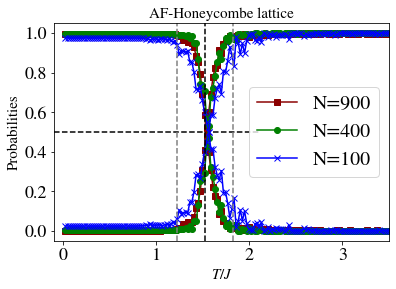

In [ ]:
###predicciones:

p1_list=[];
p2_list=[];
k=0
for k in range (Nfiles):
  T_list,x,y=ProbabilityPredictions(modellist[k],Dicyslist[k]['data'][2],Dicyslist[k]['data'][4])
  p1_list.append(x)
  p2_list.append(y)

#plot honey
Tc=Dicyslist[0]['Tc']
markers=['s','o','x','p']
colors=['darkred','green','blue']

fig = plt.figure() # crea la figura fig, sin nada, que puede tener muchas subfiguras.
ax = fig.add_subplot(111) # creo la subfigura  de 1x1 (cuadrada), numero 1. 
from google.colab import files
file_name="dense_Honey_seccion1.pdf"

for k in range(Nfiles):
  size='N='+str(Dicyslist[k]['L']**2)
  plt.plot(T_list, p1_list[k], label=size, c=colors[k],marker=markers[k])#,mfc='none') #
  plt.plot(T_list, p2_list[k], c=colors[k],marker=markers[k])#,mfc='none')#, label='')


plt.title('AF-Honeycombe lattice',size = 15)
plt.xlabel(r'$T/J$',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.legend(loc='best',prop={'size': 20})
plt.axvline(x=Tc,color='black',linestyle='--')
plt.axvline(x=Tc-a,color='gray',linestyle='--')
plt.axvline(x=Tc+a,color='gray',linestyle='--')
xmaxx=3.5
plt.hlines(y=0.5,xmin=-0.1,xmax=0.6*xmaxx,color='black',linestyle='--')

ax.set_xlim(-0.1,xmaxx)
plt.savefig(file_name)
plt.show()


In [ ]:
files.download(file_name) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>